# Tutorial: Perturbation simulation

In this tutorial we illustrate how the predictions from SCENIC+ can be utilized to simulate the effect of transcription factor perturbations.

Here, the predictions of SCENIC+ serve as a feature selection method. We will use the expression of transcription factors (TFs) as predictors for their target gene expression. For this a random forest regression model will be fitted for each gene with the expression of TFs which are predicted to regulate them by SCENIC+ as predictor for their target gene expression. After fitting the models we can alter the expression of a TF of choice and we can simulate a new gene expression matrix. This simulation is repeated for several iterations to simulate indirect effects. The simulated cells in this new matrix can be projected in an embedding of choice to visualize the effect of the perturbation.

This tutorial is based on the SCENIC+ tutorial:

https://scenicplus.readthedocs.io/en/latest/tutorials.html

with the adjustments made by Liya Zaygerman.

In [48]:
import mudata
import os
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import matplotlib
import matplotlib.pyplot as plt
import adjustText
import mudata
from pathlib import Path
# set the base directory
BASE_DIR = '/Users/liya/Documents/Biohack24/SCENIC+' # change this to your base directory
os.chdir(BASE_DIR)
#check what the current working directory is
os.getcwd()

'/Users/liya/Documents/Biohack24/SCENIC+'

In [49]:
from scenicplus.simulation import (
    train_gene_expression_models,
    simulate_perturbation,
    plot_perturbation_effect_in_embedding
)

In [50]:
%matplotlib inline

In [51]:
# set the data directory
data_dir = Path(BASE_DIR,  "scenicplus" ,  "scplus_pipeline" ,  "Snakemake")

In [7]:
scplus_mdata = mudata.read(os.path.join(data_dir, "scplusmdata.h5mu"))

/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homeb

In [6]:
scplus_mdata # LZ

MuData object with n_obs × n_vars = 1966 × 472859
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	1966 x 36601
      obs:	'VSN_cell_type', 'VSN_leiden_res0.3', 'VSN_leiden_res0.6', 'VSN_leiden_res0.9', 'VSN_leiden_res1.2', 'VSN_sample_id', 'Seurat_leiden_res0.6', 'Seurat_leiden_res1.2', 'Seurat_cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      obsm:	'X_pca', 'X_umap'
    scATAC_counts:	1966 x 435872
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'VSN_cell_type', 'VSN_leiden_res0.3', 'VSN_leiden_res0.6', 'VSN_leiden_res0.9', 'VSN_leiden_res1.2', 'VSN_sample_id', 'Seurat_leiden_res0.6', 'Seurat_leiden_res1.2', 'Seurat_cell_type', 'Doublet_scores_fragments', 'Predicted_doublets_fragments'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	1966 x 117
    direct_region_based_AUC:	1966 x 117
    extended_gene_based_AUC:	1966 x 76
    extended_region_based_AUC:	1966 x 76

In [8]:
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)
eRegulon_gene_AUC.obs = scplus_mdata.obs

In [9]:
eRegulon_gene_AUC

AnnData object with n_obs × n_vars = 1966 × 193
    obs: 'scRNA_counts:VSN_cell_type', 'scRNA_counts:VSN_leiden_res0.3', 'scRNA_counts:VSN_leiden_res0.6', 'scRNA_counts:VSN_leiden_res0.9', 'scRNA_counts:VSN_leiden_res1.2', 'scRNA_counts:VSN_sample_id', 'scRNA_counts:Seurat_leiden_res0.6', 'scRNA_counts:Seurat_leiden_res1.2', 'scRNA_counts:Seurat_cell_type', 'scRNA_counts:n_genes_by_counts', 'scRNA_counts:total_counts', 'scRNA_counts:total_counts_mt', 'scRNA_counts:pct_counts_mt', 'scATAC_counts:cisTopic_nr_frag', 'scATAC_counts:cisTopic_log_nr_frag', 'scATAC_counts:cisTopic_nr_acc', 'scATAC_counts:cisTopic_log_nr_acc', 'scATAC_counts:sample_id', 'scATAC_counts:barcode_rank', 'scATAC_counts:total_fragments_count', 'scATAC_counts:log10_total_fragments_count', 'scATAC_counts:unique_fragments_count', 'scATAC_counts:log10_unique_fragments_count', 'scATAC_counts:total_fragments_in_peaks_count', 'scATAC_counts:log10_total_fragments_in_peaks_count', 'scATAC_counts:unique_fragments_in_peaks_cou

In [10]:
sc.pp.pca(eRegulon_gene_AUC)

In [11]:
eRegulon_gene_AUC.obs

,scRNA_counts:VSN_cell_type,scRNA_counts:VSN_leiden_res0.3,scRNA_counts:VSN_leiden_res0.6,scRNA_counts:VSN_leiden_res0.9,scRNA_counts:VSN_leiden_res1.2,scRNA_counts:VSN_sample_id,scRNA_counts:Seurat_leiden_res0.6,scRNA_counts:Seurat_leiden_res1.2,scRNA_counts:Seurat_cell_type,scRNA_counts:n_genes_by_counts,...,scATAC_counts:VSN_leiden_res0.3,scATAC_counts:VSN_leiden_res0.6,scATAC_counts:VSN_leiden_res0.9,scATAC_counts:VSN_leiden_res1.2,scATAC_counts:VSN_sample_id,scATAC_counts:Seurat_leiden_res0.6,scATAC_counts:Seurat_leiden_res1.2,scATAC_counts:Seurat_cell_type,scATAC_counts:Doublet_scores_fragments,scATAC_counts:Predicted_doublets_fragments
GTTCACCTCCAAATCA-1-10x_multiome_brain,AST_CER,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_2 (5),10x_multiome_brain,BG (2),BG (2),BG,2469,...,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_2 (5),10x_multiome_brain,BG (2),BG (2),BG,0.056356,False
TCCCGTTAGGTAAGGC-1-10x_multiome_brain,MOL_B,MOL_B (0),MOL_B_2 (3),MOL_B_2 (3),MOL_B_2 (2),10x_multiome_brain,MOL (0),MOL (0),MOL,1061,...,MOL_B (0),MOL_B_2 (3),MOL_B_2 (3),MOL_B_2 (2),10x_multiome_brain,MOL (0),MOL (0),MOL,0.148936,False
AAACCAACATAGACCC-1-10x_multiome_brain,MOL_B,MOL_B (0),MOL_B_1 (0),MOL_B_3 (5),MOL_B_4 (4),10x_multiome_brain,NFOL (1),NFOL (3),NFOL,2315,...,MOL_B (0),MOL_B_1 (0),MOL_B_3 (5),MOL_B_4 (4),10x_multiome_brain,NFOL (1),NFOL (3),NFOL,0.167095,False
TTGCAACAGGATCACT-1-10x_multiome_brain,AST_CER,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_1 (7),10x_multiome_brain,BG (2),BG (2),BG,2845,...,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_1 (7),10x_multiome_brain,BG (2),BG (2),BG,0.056356,False
AACTCACAGTTTAACG-1-10x_multiome_brain,MOL_B,MOL_B (0),MOL_B_1 (0),MOL_B_3 (5),MOL_B_4 (4),10x_multiome_brain,NFOL (1),NFOL (3),NFOL,3227,...,MOL_B (0),MOL_B_1 (0),MOL_B_3 (5),MOL_B_4 (4),10x_multiome_brain,NFOL (1),NFOL (3),NFOL,0.214953,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTATCCGTCTCACACC-1-10x_multiome_brain,MOL_B,MOL_B (0),MOL_B_1 (0),MOL_B_1 (1),MOL_B_1 (1),10x_multiome_brain,MOL (0),MOL (1),MOL,3194,...,MOL_B (0),MOL_B_1 (0),MOL_B_1 (1),MOL_B_1 (1),10x_multiome_brain,MOL (0),MOL (1),MOL,0.201183,False
CCTTAGTGTGCATTAG-1-10x_multiome_brain,GC,GC (4),GC (5),GC (6),GC (8),10x_multiome_brain,GC (4),GC (5),GC,4229,...,GC (4),GC (5),GC (6),GC (8),10x_multiome_brain,GC (4),GC (5),GC,0.049140,False
AACAGCAAGCTGTACG-1-10x_multiome_brain,MOL_A,MOL_A (1),MOL_A_2 (1),MOL_A_1 (0),MOL_A_2 (0),10x_multiome_brain,MOL (0),MOL (1),MOL,1880,...,MOL_A (1),MOL_A_2 (1),MOL_A_1 (0),MOL_A_2 (0),10x_multiome_brain,MOL (0),MOL (1),MOL,0.342466,True
TGGTAAACATTGTGCA-1-10x_multiome_brain,AST_CER,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_1 (7),10x_multiome_brain,BG (2),BG (2),BG,3367,...,AST_CER (2),AST_CER (2),AST_CER (2),AST_CER_1 (7),10x_multiome_brain,BG (2),BG (2),BG,0.061728,False


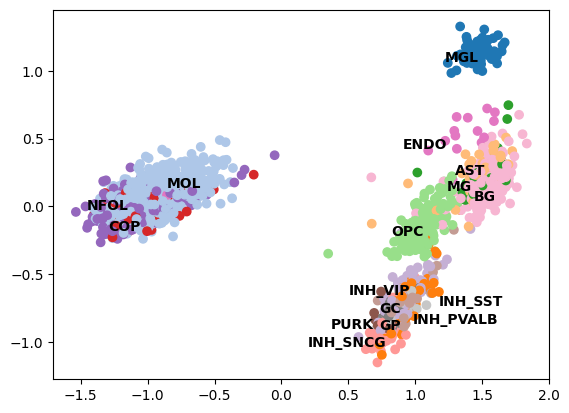

In [52]:
# Plot the PCA with the cell type labels
color_dict_line = dict(zip(
    set(eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"]),
    matplotlib.cm.get_cmap("tab20").colors
))

def plot_mm_line_pca(ax):
    texts = []
    # Plot PCA
    ax.scatter(
        eRegulon_gene_AUC.obsm["X_pca"][:, 0],
        eRegulon_gene_AUC.obsm["X_pca"][:, 1],
        color = [color_dict_line[line] for line in eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"]]
    )
    # Plot labels
    for line in set(eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"]):
        line_bc_idc = np.arange(len(eRegulon_gene_AUC.obs_names))[eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"] == line]
        avg_x, avg_y = eRegulon_gene_AUC.obsm["X_pca"][line_bc_idc, 0:2].mean(0)
        texts.append(
            ax.text(
                avg_x,
                avg_y,
                line,
                fontweight = "bold"
            )
        )
    adjustText.adjust_text(texts)

fig, ax = plt.subplots()
plot_mm_line_pca(ax)


In [53]:
# get available cell types (Seurat_cell_type) in the dataset
cell_types = set(eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"])
cell_types

{'AST',
 'BG',
 'COP',
 'ENDO',
 'GC',
 'GP',
 'INH_PVALB',
 'INH_SNCG',
 'INH_SST',
 'INH_VIP',
 'MG',
 'MGL',
 'MOL',
 'NFOL',
 'OPC',
 'PURK'}

In [14]:
gene_tf_direct_extended = pd.concat(
    [
        scplus_mdata.uns["direct_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates(),
        scplus_mdata.uns["extended_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates()
    ]
).drop_duplicates()
gene_to_TF = gene_tf_direct_extended.groupby("Gene")["TF"].apply(lambda tfs: list(tfs)).to_dict()

In [35]:
# searching for potential genes from the database in this dataset

gene_names = ["TP53",
    "CTXOE03", "OTX2", "POSTN", "TFAP4", "MYCN", "HES6", "JARID1A", "LYAR",
    "MYCN", "SSRP1", "KDM5A", "CREBBP", "PTPN14", "TP53", "YY1", "RELA", "CIC"
] # genes we chose from the database

# check if any of the genes we want are in the gene_to_TF dictionary
genes_we_want = []
for gene in gene_names:
    if gene not in gene_to_TF:
        print(f"no")
    else:
        print(f"Gene {gene} found in the gene_to_TF dictionary.")
        genes_we_want.append(gene)

# print the genes we want which are in the gene_to_TF dictionary
genes_we_want

Gene TP53 found in the gene_to_TF dictionary.
no
no
no
no
no
no
no
Gene LYAR found in the gene_to_TF dictionary.
no
Gene SSRP1 found in the gene_to_TF dictionary.
no
no
Gene PTPN14 found in the gene_to_TF dictionary.
Gene TP53 found in the gene_to_TF dictionary.
Gene YY1 found in the gene_to_TF dictionary.
no
no


['TP53', 'LYAR', 'SSRP1', 'PTPN14', 'TP53', 'YY1']

In [36]:
# gene we want to simulate perturbation for
gene_to_perturb = genes_we_want[0]
gene_to_perturb

'TP53'

In [37]:
# gene_to_TF["OLIG2"]
gene_to_TF[gene_to_perturb]

['PRDM16', 'PML']

In [38]:
# use a subset of genes, just so the notebook runs fast
genes_to_use = scplus_mdata.uns["direct_e_regulon_metadata"].sort_values("triplet_rank")["Gene"].iloc[0:5_000].drop_duplicates()

In [39]:
regressors = train_gene_expression_models(
    df_EXP = scplus_mdata["scRNA_counts"].to_df(),
    gene_to_TF = gene_to_TF,
    genes = genes_to_use,
)

100%|██████████| 2285/2285 [04:27<00:00,  8.53it/s]


In [40]:
# knockdown
perturbation_over_iter = simulate_perturbation(
    df_EXP = scplus_mdata["scRNA_counts"].to_df(),
    perturbation = {gene_to_perturb: 0},
    keep_intermediate = True,
    n_iter = 5,
    regressors = regressors
)

In [41]:
# get the list of genes that were perturbed
genes = perturbation_over_iter[0].columns

In [44]:
# get the list of genes that were perturbed as a dataframe with the log2 fold change scores

genes_to_show = genes  # Ensure this is a list of gene names
iterations = np.arange(1, 6)  # Iterations from 1 to 5

# Function to reshape and group data
def reshape_and_group(dataframe, cell_type_series, genes):
    # Add cell type information to the DataFrame
    dataframe['cell_type'] = cell_type_series.values
    
    # Reshape the DataFrame from wide to long format
    df_long = dataframe.melt(
        id_vars=['cell_type'],
        value_vars=genes,
        var_name='gene',
        value_name='expression'
    )
    
    # Group by both cell type and gene, and compute the mean expression
    grouped = df_long.groupby(['cell_type', 'gene']).mean().reset_index()
    return grouped

# Calculate the baseline values for all cell types and genes
baseline_grouped = reshape_and_group(
    perturbation_over_iter[0].copy(),
    eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"],
    genes_to_show
)

# Initialize a list to store DataFrames for each iteration
log2fc_list = []

for i in iterations:
    # Reshape and group the data for the current iteration
    iter_grouped = reshape_and_group(
        perturbation_over_iter[i].copy(),
        eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"],
        genes_to_show
    )
    
    # Merge with baseline to calculate log2FC
    merged = iter_grouped.merge(
        baseline_grouped,
        on=['cell_type', 'gene'],
        suffixes=('', '_baseline')
    )
    
    # Calculate log2 fold change
    merged['log2FC'] = np.log2(merged['expression'] / merged['expression_baseline'])
    merged['Iteration'] = i  # Add iteration information
    
    # Append to the list
    log2fc_list.append(merged[['Iteration', 'cell_type', 'gene', 'log2FC']])

# Concatenate all iterations into a single DataFrame
log2fc_df = pd.concat(log2fc_list, ignore_index=True)

# Save the log2FC values to a CSV file
log2fc_df.to_csv('log2fc_values_all_cell_types_genes.csv', index=False)
log2fc_df

/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inp

,Iteration,cell_type,gene,log2FC
0,1,AST,A1BG,NaN
1,1,AST,A1BG-AS1,NaN
2,1,AST,A1CF,NaN
3,1,AST,A2M,NaN
4,1,AST,A2M-AS1,-2.727052e-08
...,...,...,...,...
2928075,5,PURK,ZYG11B,4.424125e-08
2928076,5,PURK,ZYX,-3.481745e-08
2928077,5,PURK,ZZEF1,6.907397e-08
2928078,5,PURK,hsa-mir-1253,NaN


In [46]:
# take only the results from the last iteration
per_gene_df = log2fc_df[log2fc_df["Iteration"] == log2fc_df["Iteration"].max()].groupby("gene").max().sort_values("log2FC", ascending = False).dropna()

per_gene_df


/var/folders/3k/cqqc2z2j7vn33x80p0ssjd3r0000gn/T/ipykernel_4697/322223249.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  per_gene_df = log2fc_df[log2fc_df["Iteration"] == log2fc_df["Iteration"].max()].groupby("gene").max().sort_values("log2FC", ascending = False).dropna()


,Iteration,log2FC
gene,,
ARHGAP24,5,1.922177e-07
LINC02615,5,1.914547e-07
SLC25A3,5,1.903031e-07
LIN7A,5,1.888500e-07
ZSCAN16,5,1.836751e-07
...,...,...
LINC01104,5,-1.253370e-07
LINC01788,5,-1.298437e-07
FITM1,5,-1.299150e-07


In [47]:
highest = per_gene_df.head(50)
# #lowest = per_gene_df.tail(10)

# print(f"higest: {highest}")
# #print(f"lowest: {lowest}")

# save the top 50 genes with highest log2FC to a csv file
highest.to_csv(f"SCENIC+_TP53_top50.csv")

  0%|          | 0/2280 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1642: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1642: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
  4%|▍         | 102/2280 [00:00<00:02, 1016.05it/s]/opt/homebrew/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1642: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

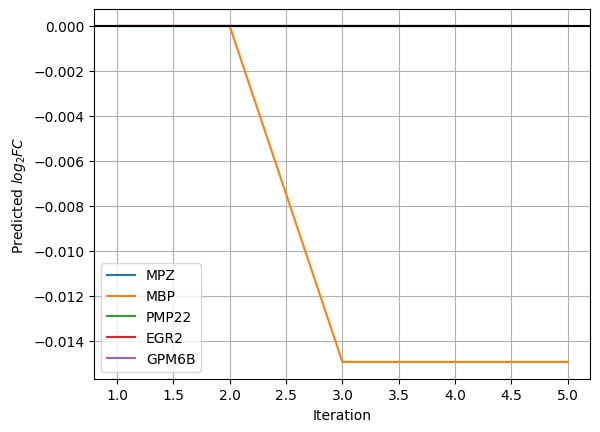

In [66]:
#ok then, let's try to overexpress SOX10 in MGL cells
perturbation_over_iter = simulate_perturbation(
    df_EXP = scplus_mdata["scRNA_counts"].to_df(),
    perturbation = {gene_to_perturb: 10},
    keep_intermediate = True,
    n_iter = 5,
    regressors = regressors
)   
 
cell_type = "MGL"

genes_to_show = ["MPZ", "MBP", "PMP22", "EGR2", "GPM6B"]


fig, ax = plt.subplots()
baseline = perturbation_over_iter[0].groupby(eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"]).mean().loc[cell_type, genes_to_show]
for gene in genes_to_show:
    ax.plot(
        np.arange(5) + 1,
        [
            np.log2(perturbation_over_iter[i].groupby(eRegulon_gene_AUC.obs["scRNA_counts:Seurat_cell_type"]).mean().loc[cell_type, gene] / baseline[gene])
            for i in np.arange(5) + 1
        ],
        label = gene
    )
ax.set_ylabel("Predicted $log{_2}FC$")
ax.set_xlabel("Iteration")
ax.legend()
ax.axhline(y = 0, color = "black")
ax.grid("gray")
ax.set_axisbelow(True)

In [47]:
import velocyto

ModuleNotFoundError: No module named 'velocyto'

In [62]:
# fig, ax = plt.subplots()
# plot_mm_line_pca(ax)
# plot_perturbation_effect_in_embedding(
#     perturbed_matrix = perturbation_over_iter[5],
#     original_matrix = perturbation_over_iter[0],
#     embedding = eRegulon_gene_AUC.obsm["X_pca"][:, 0:2],
#     AUC_kwargs = {},
#     ax = ax,
#     eRegulons = pd.concat(
#         [
#             scplus_mdata.uns["direct_e_regulon_metadata"],
#             scplus_mdata.uns["extended_e_regulon_metadata"]
#         ]
#     ),
#     n_cpu = 10
# )
import scvelo
# I need to do the same but without using velocyto. Use scvelo instead
scvelo.pp.pca(scplus_mdata["scRNA_counts"])
scvelo.pp.neighbors(scplus_mdata["scRNA_counts"])
scvelo.tl.umap(scplus_mdata["scRNA_counts"])
scvelo.pl.velocity_embedding_stream(
    scplus_mdata["scRNA_counts"],
    basis = "umap",
    color = "scRNA_counts:Seurat_cell_type",
)


computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding


KeyError: 'velocity'